# Logistic Regression

## Overview

Logistic regression is an extension on linear regression (both are generalized linear methods). We will still learn to model a line (plane) that models $y$ given $X$. Except now we are dealing with classification problems as opposed to regression problems so we'll be predicting probability distributions as opposed to discrete values. We'll be using the softmax operation to normalize our logits ($XW$) to derive probabilities.

Our goal is to learn a logistic model $\hat{y}$ that models $y$ given $X$.

$$\hat{y} = \frac{e^{XW_y}}{\sum_j e^{XW}}$$

VARIABLE: DESCRIPTION

$N$: total number of samples

$C$: number of classes

$\hat{y}$: predictions $\in \mathbb{R}^{NXC}$

$X$: inputs $\in \mathbb{R}^{NXD}$

$W$: weights $\in \mathbb{R}^{DXC}$


This function is known as the multinomial logistic regression or the softmax classifier. The softmax classifier will use the linear equation ( $z=XW$ ) and normalize it (using the softmax function) to produce the probability for class y given the inputs.

### Objectives:

- Predict the probability of class $y$ given the inputs $X$. The softmax classifier normalizes the linear outputs to determine class probabilities.

### Advantages:

- Can predict class probabilities given a set on inputs.

### Disadvantages:

- Sensitive to outliers since objective is to minimize cross entropy loss. Support vector machines (SVMs) are a good alternative to counter outliers.

### Miscellaneous:

- Softmax classifier is widely in neural network architectures as the last layer since it produces class probabilities.

---
## Set up

In [82]:
import numpy as np
import random

In [83]:
SEED = 1234

In [84]:
# Set seed for reproducibility
np.random.seed(SEED)
random.seed(SEED)

## Load data

In [85]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix

In [86]:
SEED = 1234

In [87]:
# Set seed for reproducibility
np.random.seed(SEED)

In [88]:
# Read from CSV to Pandas DataFrame
url = "https://raw.githubusercontent.com/ranjian0/basics/master/data/tumors.csv"
df = pd.read_csv(url, header=0) # load
df = df.sample(frac=1).reset_index(drop=True) # shuffle
df.head()

,leukocyte_count,blood_pressure,tumor_class
0,15.335860,14.637535,benign
1,9.857535,14.518942,malignant
2,17.632579,15.869585,benign
3,18.369174,14.774547,benign
4,14.509367,15.892224,malignant


In [89]:
# Define X and y
X = df[["leukocyte_count", "blood_pressure"]].values
y = df["tumor_class"].values

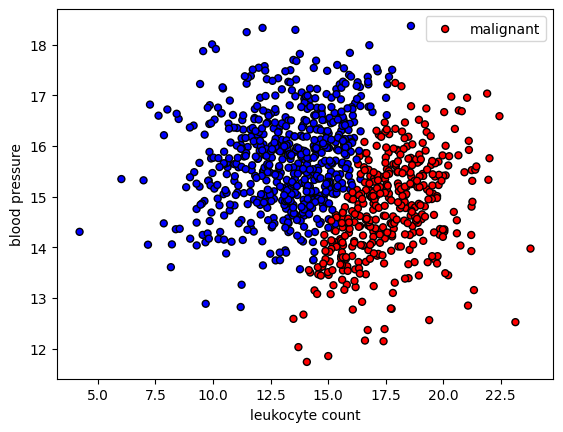

In [90]:
# Plot data
colors = {"benign": "red", "malignant": "blue"}
plt.scatter(X[:, 0], X[:, 1], c=[colors[_y] for _y in y], s=25, edgecolors="k")
plt.xlabel("leukocyte count")
plt.ylabel("blood pressure")
plt.legend(["malignant", "benign"], loc="upper right")
plt.show()

## Split Data

In [91]:
import collections
from sklearn.model_selection import train_test_split

In [92]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [93]:
def train_val_test_split(X, y, train_size):
    """Split dataset into data splits."""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [94]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, train_size=TRAIN_SIZE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")

X_train: (700, 2), y_train: (700,)
X_val: (150, 2), y_val: (150,)
X_test: (150, 2), y_test: (150,)
Sample point: [14.95081332 14.86441305] → malignant


In [95]:
# Overall class distribution
class_counts = dict(collections.Counter(y))
print (f"Classes: {class_counts}")
print (f'm:b = {class_counts["malignant"]/class_counts["benign"]:.2f}')

Classes: {'benign': 389, 'malignant': 611}
m:b = 1.57


In [96]:
# Per data split class distribution
train_class_counts = dict(collections.Counter(y_train))
val_class_counts = dict(collections.Counter(y_val))
test_class_counts = dict(collections.Counter(y_test))
print (f'train m:b = {train_class_counts["malignant"]/train_class_counts["benign"]:.2f}')
print (f'val m:b = {val_class_counts["malignant"]/val_class_counts["benign"]:.2f}')
print (f'test m:b = {test_class_counts["malignant"]/test_class_counts["benign"]:.2f}')

train m:b = 1.57
val m:b = 1.54
test m:b = 1.59


## Label encoding

In [97]:
import itertools
import json

In [98]:
class LabelEncoder(object):
    """Label encoder for tag labels."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}  # mutable defaults ;)
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {'class_to_index': self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [99]:
# Fit
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
label_encoder.class_to_index

{'benign': 0, 'malignant': 1}

In [100]:
# Encoder
print (f"y_train[0]: {y_train[0]}")
y_train = label_encoder.encode(y_train)
y_val = label_encoder.encode(y_val)
y_test = label_encoder.encode(y_test)
print (f"y_train[0]: {y_train[0]}")
print (f"decoded: {label_encoder.decode([y_train[0]])}")

y_train[0]: malignant
y_train[0]: 1
decoded: ['malignant']


In [101]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"counts: {counts}\nweights: {class_weights}")

counts: [272 428]
weights: {0: 0.003676470588235294, 1: 0.002336448598130841}


## Standardize data

In [102]:
from sklearn.preprocessing import StandardScaler

In [103]:
# Standardize the data (mean=0, std=1) using training data
X_scaler = StandardScaler().fit(X_train)

In [104]:
# Apply scaler on training and test data (don't standardize outputs for classification)
X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)

In [105]:
# Check (means should be ~0 and std should be ~1)
print (f"X_test[0]: mean: {np.mean(X_test[:, 0], axis=0):.1f}, std: {np.std(X_test[:, 0], axis=0):.1f}")
print (f"X_test[1]: mean: {np.mean(X_test[:, 1], axis=0):.1f}, std: {np.std(X_test[:, 1], axis=0):.1f}")

X_test[0]: mean: -0.1, std: 1.0
X_test[1]: mean: -0.1, std: 1.0


---
## PyTorch

In [106]:
# Hyperparameters
LEARNING_RATE = 1e-1
NUM_EPOCHS = 50

INPUT_DIM = X_train.shape[1] # X is 2-dimensional
NUM_CLASSES = len(label_encoder.classes) # y has two possibilities (benign or malignant)

In [107]:
import torch

In [108]:
# Set seed for reproducibility
torch.manual_seed(SEED)

### Model

In [109]:
from torch import nn
import torch.nn.functional as F

In [110]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.fc1 = nn.Linear(input_dim, num_classes)

    def forward(self, x_in):
        z = self.fc1(x_in)
        return z

In [111]:
# Initialize model
model = LogisticRegression(input_dim=INPUT_DIM, num_classes=NUM_CLASSES)
print (model.named_parameters)

<bound method Module.named_parameters of LogisticRegression(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
)>


### Loss

In [112]:
loss_fn = nn.CrossEntropyLoss()
y_pred = torch.randn(3, NUM_CLASSES, requires_grad=False)
y_true = torch.empty(3, dtype=torch.long).random_(NUM_CLASSES)
print (y_true)
loss = loss_fn(y_pred, y_true)
print(f"Loss: {loss.numpy()}")

tensor([0, 0, 0])
Loss: 1.2779091596603394


In [113]:
# Define Loss
class_weights_tensor = torch.Tensor(list(class_weights.values()))
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

### Metrics

In [114]:
# Accuracy
def accuracy_fn(y_pred, y_true):
    n_correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = (n_correct / len(y_pred)) * 100
    return accuracy

In [115]:
y_pred = torch.Tensor([0, 0, 1])
y_true = torch.Tensor([1, 1, 1])
print("Accuracy: {accuracy_fn(y_pred, y_true):.1f}")

Accuracy: {accuracy_fn(y_pred, y_true):.1f}


### Optimizer

In [116]:
from torch.optim import Adam

In [117]:
# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

### Training

In [118]:
# Convert data to tensors
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)

In [119]:
# Training
for epoch in range(NUM_EPOCHS):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%10==0:
        predictions = y_pred.max(dim=1)[1] # class
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print (f"Epoch: {epoch} | loss: {loss:.2f}, accuracy: {accuracy:.1f}")

Epoch: 0 | loss: 0.96, accuracy: 60.7
Epoch: 10 | loss: 0.28, accuracy: 87.0
Epoch: 20 | loss: 0.15, accuracy: 95.6
Epoch: 30 | loss: 0.12, accuracy: 97.7
Epoch: 40 | loss: 0.10, accuracy: 98.3


### Evaluation

In [120]:
from sklearn.metrics import accuracy_score

In [121]:
# Predictions
pred_train = F.softmax(model(X_train), dim=1)
pred_test = F.softmax(model(X_test), dim=1)
print (f"sample probability: {pred_test[0]}")
pred_train = pred_train.max(dim=1)[1]
pred_test = pred_test.max(dim=1)[1]
print (f"sample class: {pred_test[0]}")

sample probability: tensor([0.0449, 0.9551], grad_fn=<SelectBackward0>)
sample class: 1


In [122]:
# Accuracy (could've also used our own accuracy function)
train_acc = accuracy_score(y_train, pred_train)
test_acc = accuracy_score(y_test, pred_test)
print (f"train acc: {train_acc:.2f}, test acc: {test_acc:.2f}")

train acc: 0.98, test acc: 0.98


In [123]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

In [124]:
def get_metrics(y_true, y_pred, classes):
    """Per-class performance metrics."""
    # Performance
    performance = {"overall": {}, "class": {}}

    # Overall performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = metrics[0]
    performance["overall"]["recall"] = metrics[1]
    performance["overall"]["f1"] = metrics[2]
    performance["overall"]["num_samples"] = np.float64(len(y_true))

    # Per-class performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i]),
        }

    return performance

In [125]:
# # Performance
performance = get_metrics(y_true=y_test, y_pred=pred_test, classes=label_encoder.classes)
print (json.dumps(performance, indent=2))

{
  "overall": {
    "precision": 0.9800264101112998,
    "recall": 0.98,
    "f1": 0.9799670975323149,
    "num_samples": 150.0
  },
  "class": {
    "benign": {
      "precision": 0.9824561403508771,
      "recall": 0.9655172413793104,
      "f1": 0.9739130434782608,
      "num_samples": 58.0
    },
    "malignant": {
      "precision": 0.978494623655914,
      "recall": 0.9891304347826086,
      "f1": 0.9837837837837837,
      "num_samples": 92.0
    }
  }
}


In [126]:
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = plt.cm.Spectral

    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = F.softmax(model(X_test), dim=1)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

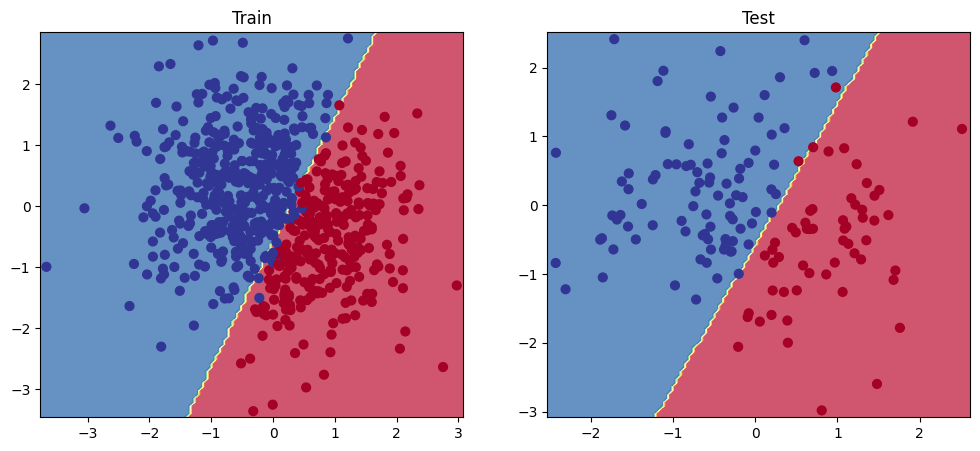

In [127]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

### Inference

In [128]:
# Inputs for inference
X_infer = pd.DataFrame([{"leukocyte_count": 13, "blood_pressure": 12}])

In [129]:
# Standardize
X_infer = X_scaler.transform(X_infer)
print (X_infer)

[[-0.68505296 -3.11487099]]


C:\Users\ardiz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [130]:
# Predict
y_infer = F.softmax(model(torch.Tensor(X_infer)), dim=1)
prob, _class = y_infer.max(dim=1)
label = label_encoder.decode(_class.detach().numpy())[0]
print (f"The probability that you have a {label} tumor is {prob.detach().numpy()[0]*100.0:.0f}%")

The probability that you have a benign tumor is 93%


### Unscaled weights

In [131]:
# Unstandardize weights
W = model.fc1.weight.data.numpy()
b = model.fc1.bias.data.numpy()
W_unscaled = W / X_scaler.scale_
b_unscaled = b - np.sum((W_unscaled * X_scaler.mean_))
print (W_unscaled)
print (b_unscaled)

[[ 0.61299727 -1.18550925]
 [-0.95371068  0.88432909]]
[ 8.929323 10.233843]
